In [1]:
from collections import OrderedDict
import configparser
from functools import partial
import time
import numpy as np
from shapely import Polygon
import math
from typing import Any
from matplotlib.backend_bases import MouseEvent, MouseButton
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
import logging
from shapely import Point, Polygon


import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))



logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)


In [1]:
from typing import Mapping

from bbtoolkit.dynamics.callbacks import BaseCallback


class HDCallback(BaseCallback):
    def __init__(
        self,
        init_timesteps: int = 30,
        hd_cue_scale: float = 60,
    ):
        super().__init__()
        self.init_timesteps = init_timesteps
        self.hd_cue_scale = hd_cue_scale
        self.total_steps = None
        self.mode = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):

        self.requires = [
            'dynamics_params',  # Dynamic parameters including dt, mode, and step.
            'tc_gen',  # Transformation circuit generator for HD activity.
            'movement_params',  # Movement parameters including position and direction.
            'mental_movement_params',  # Mental movement parameters for cognitive navigation.
            'hd_cue',  # HD cue array for external directional cues.
            'k_ratio',  # Ratio of excitation/inhibition for HD cells.
            'activity',  # Neural activity levels.
            'connectivity',  # Connectivity matrices between neural populations.
            'weights',  # Synaptic weights between neurons.
            'rates'  # Firing rates of neurons.
        ]

        cache['hd_cue'] = np.zeros(len(cache['weights'].hd.to.hd))
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params['dt']

    def on_step_begin(self, step: int):
        if self.mode != self.dynamics_params['mode']:
            if self.dynamics_params['mode'] not in self.no_cue_reset_modes:
                self.total_steps = self.init_timesteps

            self.mode = self.dynamics_params['mode']

        if self.total_steps == self.init_timesteps:
            logging.debug('HD CUE INITIATED')


        if self.total_steps != 0:
            self.total_steps -= 1
            self.hd_cue += self.hd_cue_scale*self.tc_gen.get_hd_activity(np.array([self.movement_params.direction]))
        else:
            if not np.all(self.hd_cue == 0):
                logging.debug('HD CUE REMOVED')
                self.hd_cue *= 0

        rot_weights = None
        match self.dynamics_params['mode']:
            case 'bottom-up':
                params = self.movement_params
                target = self.movement_params.move_target if self.movement_params.move_target is not None else self.movement_params.rotate_target
                position = self.movement_params.position
                direction = self.movement_params.direction
            case 'top-down':
                params = self.mental_movement_params
                target = self.mental_movement_params.move_target if self.mental_movement_params.move_target is not None else self.mental_movement_params.rotate_target
                position = self.mental_movement_params.position
                direction = self.mental_movement_params.direction
            case 'recall':
                params, target, position, direction = None, None, None, None

        if target is not None:
            angle_to_target = math.atan2(
                target[1] - position[1],
                target[0] - position[0]
            ) % (2*np.pi)

            diff = angle_to_target - direction
            if diff > np.pi:
                diff -= 2*np.pi
            elif diff < -np.pi:
                diff += 2*np.pi

            if diff < 0:
                rot_weights = self.weights.rot.to.rot.T
            elif diff > 0:
                rot_weights = self.weights.rot.to.rot
            elif np.isclose(angle_to_target, direction):
                rot_weights = None

        if rot_weights is None:
            rot_weights = np.zeros_like(self.weights.rot.to.rot)

        self.k_ratio.hd = -self.activity.hd +\
            (self.connectivity.hd.to.hd['phi']*self.weights.hd.to.hd@self.rates.hd) +\
            self.hd_cue[:, np.newaxis] +\
            (self.connectivity.rot.to.rot['phi']*rot_weights@self.rates.hd)

        if self.dynamics_params['mode'] in ('recall', 'top-down'):
            self.k_ratio.hd += self.connectivity.opr.to.hd['phi'] * self.weights.opr.to.hd@self.rates.opr

        self.activity.hd += self.dt/self.connectivity.hd.to.hd['tau']*self.k_ratio.hd
        self.rates.hd = 1/(1 + np.exp(-2*self.connectivity.hd.to.hd['beta']*(self.activity.hd - self.connectivity.hd.to.hd['alpha'])))

        # HD estimation
        if self.total_steps == 0 and self.dynamics_params['mode'] != 'recall':
            popmax = np.where(self.rates.hd == np.max(self.rates.hd))[0][0]
            hd_estim = popmax*2*np.pi/(len(self.rates.hd) - 1) % (2*np.pi)

            params.direction = hd_estim

ModuleNotFoundError: No module named 'bbtoolkit'

In [3]:
from bbtoolkit.dynamics.callbacks.viz import ArtistCallback


class TimerPlotter(ArtistCallback):
    def __init__(self, coords: tuple[float, float]):
        super().__init__()
        self.coords = coords

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['time_ax'] = cache.fig.add_subplot(cache.gc[:1, 1])
        self.requires = ['time_ax', 'dynamics_params']
        super().set_cache(cache, on_repeat)

    def plot(self):
        self.time_ax.text(*self.coords, f'Time: {(self.dynamics_params.step)*self.dynamics_params.dt : .2f} s')

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.time_ax.clear()
        self.time_ax.set_axis_off()

In [4]:
class PolarCirclePlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['main_ax'] = cache.fig.add_subplot(cache.gc[:6, :], projection='polar')
        self.requires = [
            'main_ax',
            'movement_params',
            'fig'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        if self.movement_params.rotate_target is not None:
            self.main_ax.plot(
                [
                    self.movement_params.rotate_target,
                    self.movement_params.rotate_target
                ],
                [0, 1],
                marker='o'
            )
        if self.movement_params.direction is not None:
            self.main_ax.plot(
                [
                    self.movement_params.direction,
                    self.movement_params.direction
                ],
                [0, 1],
                marker='o',
                color='red'
            )

    def on_clean(self):
        self.main_ax.clear()

In [5]:

class MouseEventCallback(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'fig',
            'dynamics_params',
            'movement_params',
            'click_params',
            'main_ax'
        ]
        super().set_cache(cache, on_repeat)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def on_click(self, event: MouseEvent):

        if event.inaxes is self.main_ax:

            self.click_params.xy_data = (event.xdata, event.ydata)
            self.movement_params.rotate_target = event.xdata

    def on_copy(self):
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def on_load(self):
        self.on_copy()

2024-06-03 09:25:13 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-03 09:25:13 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-06-03 09:25:13 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-06-03 09:25:13 - DEBUG - findfont: score(FontEntry(fname='/home/user/Projects/SpatialMemory/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
2024-06-03 09:25:13 - DEBUG - findfont: score(FontEntry(fname='/home/user/Projects/SpatialMemory/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2024-06-03 09:25:13 - DEBUG - findfont: score(FontEntry(fname='/home/user/Proje

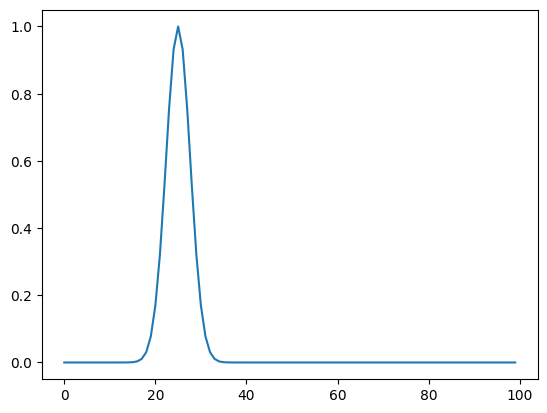

In [6]:
import numpy as np

def get_hd_cue(
    angle: float,
    n_neurons: int,
    max_amplitude: float = 1,
    angular_sigma: float = .1667
) -> np.ndarray:
    # Create a linear space from 0 to 2*pi with n elements
    x = np.linspace(0, 2 * np.pi, n_neurons, endpoint=False)

    # Ensure the angle is within the range [0, 2*pi]
    angle = angle % (2 * np.pi)

    # Calculate the distance on the ring between each point and the peak angle
    # This takes into account the wrap-around effect
    distance = np.minimum(np.abs(x - angle), 2 * np.pi - np.abs(x - angle))

    # Create a Gaussian distribution centered at the specified angle with wrap-around
    gaussian = max_amplitude * np.exp(-(distance**2) / (2 * angular_sigma**2))

    return gaussian


# Example usage
angle = np.pi/2  # 45 degrees in radians
n = 100
amplitude = 1
sigma = 0.1
gaussian_vector = get_hd_cue(angle, n)
plt.plot(gaussian_vector)

In [7]:
import numpy as np

def should_rotate_clockwise(phi1: float, phi2: float) -> bool:
    # Normalize angles to be within 0 to 2*pi radians
    phi1 = phi1 % (2 * np.pi)
    phi2 = phi2 % (2 * np.pi)

    # Calculate the difference in angles
    diff = phi2 - phi1

    # Normalize the difference to be within -pi to pi radians
    # This determines the shortest rotation direction
    if diff > np.pi:
        diff -= 2 * np.pi
    elif diff < -np.pi:
        diff += 2 * np.pi

    # If diff is positive, the shortest way is clockwise
    # If diff is negative, the shortest way is counterclockwise
    if np.isclose(diff, 0):
        return None

    return diff > 0

In [8]:
from bbtoolkit.environment import Environment
from bbtoolkit.models.bb.neural_generators import TCGenerator
from bbtoolkit.utils.datautils.configparser import EvalConfigParser


hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

env_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
env_cfg.read('../cfg/envs/squared_room.ini')

space_cfg = mtl_config['Space']
h_res = space_cfg.eval('res')
r_max = space_cfg.eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

n_steps = tr_config['Training'].eval('n_steps')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')


training_rect_cfg = env_cfg['TrainingRectangle']
max_train_x = training_rect_cfg.eval('max_train_x')
min_train_x = training_rect_cfg.eval('min_train_x')
max_train_y = training_rect_cfg.eval('max_train_y')
min_train_y = training_rect_cfg.eval('min_train_y')

# env = Environment.load('../../../Downloads/Telegram Desktop/doellerlab_env (2).pkl')
env = Environment.load('../data/envs/inserted_wall_environment.pkl')
# env = Environment.load('../data/envs/square_environment.pkl')

tc_gen = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    sigma_angular
)

In [9]:
def create_index_matrix(m, n):
    # Calculate the center indices
    center_x, center_y = m // 2, n // 2

    # Generate a matrix for x-axis indices
    x_indices = np.arange(m).reshape(m, 1) - center_x
    # Generate a matrix for y-axis indices
    y_indices = np.arange(n).reshape(1, n) - center_y

    # Tile the indices to form matrices of shape (m, n)
    x_matrix = np.tile(x_indices, (1, n))
    y_matrix = np.tile(y_indices, (m, 1))

    return x_matrix, y_matrix

create_index_matrix(5, 5)

(array([[-2, -2, -2, -2, -2],
        [-1, -1, -1, -1, -1],
        [ 0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1],
        [ 2,  2,  2,  2,  2]]),
 array([[-2, -1,  0,  1,  2],
        [-2, -1,  0,  1,  2],
        [-2, -1,  0,  1,  2],
        [-2, -1,  0,  1,  2],
        [-2, -1,  0,  1,  2]]))

In [10]:
def generate_index_shapes(shape: int) -> list[tuple[int, ...]]:
    return [(1,) * i + (shape[i],) + (1,) * (len(shape) - i - 1) for i in range(len(shape))]


def generate_tile_shapes(shape: tuple[int, ...]) -> tuple[tuple[int, ...]]:
    return tuple(tuple(1 if j == i else shape[j] for j in range(len(shape))) for i in range(len(shape)))


def create_index_matrix(shape: tuple[int, ...]) -> tuple[np.ndarray, ...]:
    # Calculate the center indices
    center = [dim//2 for dim in shape]
    indices = [
        np.arange(dim).reshape(*index_shape) - center
        for dim, center, index_shape in zip(shape, center, generate_index_shapes(shape))
    ]

    return tuple(
        np.tile(
            index, tile_shape
        )
        for index, tile_shape in zip(indices, generate_tile_shapes(shape))
    )


def select_data(data: np.ndarray, indices: np.ndarray) -> np.ndarray:
    # Check dimensions
    indices_ndim = len(indices) if isinstance(indices, tuple) else indices.ndim
    if indices_ndim >= data.ndim:
        # Directly use indices for selection
        return data[indices]
    else:
        # Prepare a tuple for advanced indexing
        idx = [slice(None)] * (data.ndim - indices_ndim) + [indices]
        print(tuple(idx))
        return data[tuple(idx)]

In [11]:
def select_data(data: np.ndarray, indices: np.ndarray) -> np.ndarray:
    # Check dimensions
    if isinstance(indices, (tuple, list)):
        indices_ndim = len(indices)
        indices = [*indices]
    else:
        indices_ndim = indices.ndim
        indices = [indices]

    if indices_ndim >= data.ndim:
        # Directly use indices for selection
        return data[indices]
    else:
        # Prepare a tuple for advanced indexing
        idx = [slice(None)] * (data.ndim - indices_ndim) + indices
        return data[tuple(idx)]


# Example usage
data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
indices = np.array([1, 0]), np.array([1, 0])

# Example call to the function
result = select_data(data, indices)
print(result)

[[[4 5 6]
  [1 2 3]]

 [[4 5 6]
  [1 2 3]]]


In [12]:
class IteratorIndexer:
    def __init__(self, shape: tuple[int, ...]):
        self.shape = shape
        self.ranges = [range(dim) for dim in shape]
        self.current = [0] * len(shape)  # Initialize current index to start of each dimension
        self.started = False  # To handle the first increment

    def __iter__(self):
        return self

    def __next__(self):
        if not self.started:
            self.started = True
            if all(size == 0 for size in self.shape):  # Handle empty shape
                raise StopIteration
            return tuple(self.current)  # Return the first index if not started

        for i in range(len(self.shape) - 1, -1, -1):
            if self.current[i] < self.shape[i] - 1:
                self.current[i] += 1
                for j in range(i + 1, len(self.shape)):
                    self.current[j] = 0
                return tuple(self.current)
            elif i == 0:
                raise StopIteration
            self.current[i] = 0  # Reset current index at dimension i and continue

# Example usage
shape = (40, 30, 50) # Example for a 2D array
iterator = IteratorIndexer(shape)

# for indices in iterator:
#     print(indices)
import time

start_time = time.time()
for indices in iterator:
    ...

end_time = time.time()

print(end_time - start_time)

0.04293036460876465


In [13]:
import re
from typing import Callable

def wrap_indices(indices: tuple[int, ...], shape: tuple[int, ...]) -> tuple[int, ...]:
    if len(indices) != len(shape):
        raise ValueError('Indices and shape must have the same length')
    return tuple((((i % s) + s) % s for i, s in zip(indices, shape)))


class WrapperIndexer:
    def __init__(self, shape: tuple[int, ...]):
        self.shape = shape

    def __getitem__(self, item: tuple[int, ...]):
        return wrap_indices(item, self.shape)

class AttractorIndexer:
    def __init__(self, shape: tuple[int, ...]):
        self.shape = shape
        self.indexer = WrapperIndexer(shape)

    def __getitem__(self, item: tuple[int, ...]):
        return np.ix_(*[
            (np.arange(dim) - shift) % dim
            for shift, dim in zip(self.indexer[item], self.shape)
        ])

class AttractorState:
    def __init__(
        self,
        kernel: np.ndarray,
        weights: np.ndarray,
        indexer: AttractorIndexer,
        inplace: bool = False
    ):
        self.kernel = kernel
        self.weights = weights
        self.indexer = indexer
        self.inplace = inplace

    @property
    def shape(self):
        return self.kernel.shape

    @property
    def ndim(self):
        return self.kernel.ndim

    def __getitem__(self, indices: np.ndarray):
        indices = wrap_indices(indices, self.kernel.shape)
        ratio = self.kernel[*indices]

        return select_data(self.weights, self.indexer[indices])*ratio

    def __matmul__(self, other: np.ndarray):
        if not self.inplace:
            other = other.copy()
        # for indices in IteratorIndexer(self.shape):
        #     if not np.isclose(self.kernel[indices], 0):
        for indices in zip(*np.nonzero(self.kernel)):
                other += self[indices]
        return other



class Attractor:
    def __init__(
        self,
        kernel: np.ndarray,
        inplace: bool = False
    ):
        self.kernel = kernel
        self.kernel_shifted = self.kernel[create_index_matrix(self.kernel.shape)]
        self.indexer = AttractorIndexer(self.shape)
        self.inplace = inplace

    @property
    def shape(self):
        return self.kernel.shape

    def __call__(self, weights: np.ndarray) -> AttractorState:
        if not self.inplace:
            weights = weights.copy()
        return AttractorState(self.kernel_shifted, weights, self.indexer, self.inplace)

2024-06-03 09:25:16 - DEBUG - Loaded backend inline version unknown.


2024-06-03 09:25:16 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x70660316ce60>


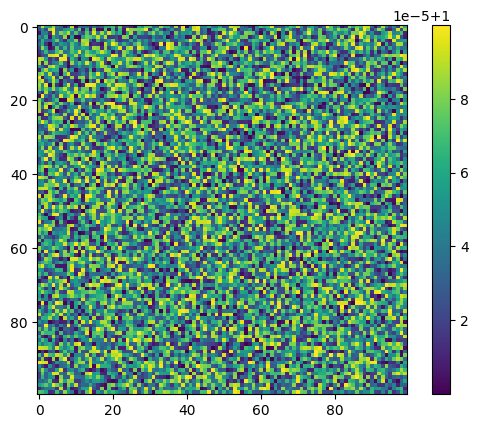

2024-06-03 09:25:17 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7066031c8a10>


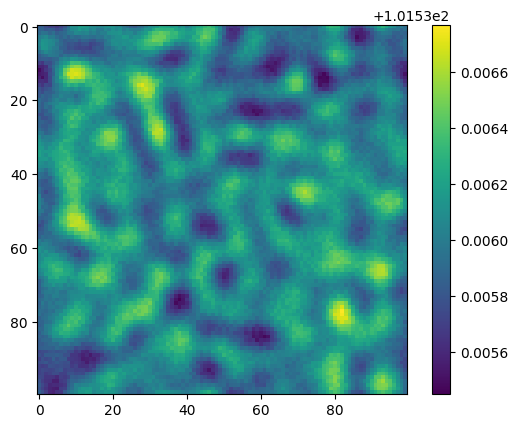

In [14]:
%matplotlib inline
def create_ricker_matrix(m, n, a=None):
    # Create an m x n matrix
    matrix = np.zeros((m, n))

    if a is None:
        a = min(m, n) // 10

    # Calculate the center of the matrix
    center_x, center_y = m // 2, n // 2

    # Iterate over the matrix to apply the Ricker wavelet function
    for i in range(m):
        for j in range(n):
            # Calculate distances from the center
            x = i - center_x
            y = j - center_y
            # Calculate the Ricker wavelet value
            factor = (x**2 + y**2) / a**2
            matrix[i, j] = (1 - factor) * np.exp(-factor / 2)

    return matrix


# all_data = np.ones((6, 6))
all_data = 1 + .0001 * np.random.rand(1, 1, 100, 100)


c = plt.imshow(all_data[0, 0])
plt.colorbar(c)
plt.show()

attr = Attractor(-create_ricker_matrix(*all_data.shape[-2:], 4))
state = attr(all_data.copy())

all_data = state@all_data.copy()

c = plt.imshow(all_data[0, 0])
plt.colorbar(c)
plt.show()

In [15]:
from bbtoolkit.models.bb.utils import activity2rate, connectivity_config2dict
from bbtoolkit.structures.tensorgroups import NamedTensor, TensorGroup, dict2directed_tensor
from bbtoolkit.utils.datautils.configparser import EvalConfigParser
from bbtoolkit.structures.tensorgroups import DirectedTensorGroup


weights = DirectedTensorGroup.load('../data/weights/hd_weights_square.pkl')
n_hd_neurons = len(weights.hd.to.hd)

activity = TensorGroup(
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
)

config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read('../cfg/connectivity/main.ini')

configdict = connectivity_config2dict(config)
connections = dict2directed_tensor(configdict)
connectivity = DirectedTensorGroup(*connections)
weights = weights.operation_with(
    connectivity,
    lambda a, b: a - b.get('inhibitory_phi', 0),
    on_missing_weights='ignore',
    on_missing_sources='ignore'
)

rates = activity2rate(activity, connectivity)

k_ratio = TensorGroup(
    NamedTensor('hd', np.zeros((n_hd_neurons, 1))),
)

In [16]:
get_hd_cue

<function __main__.get_hd_cue(angle: float, n_neurons: int, max_amplitude: float = 1, angular_sigma: float = 0.1667) -> numpy.ndarray>

In [17]:
get_hd_cue

<function __main__.get_hd_cue(angle: float, n_neurons: int, max_amplitude: float = 1, angular_sigma: float = 0.1667) -> numpy.ndarray>

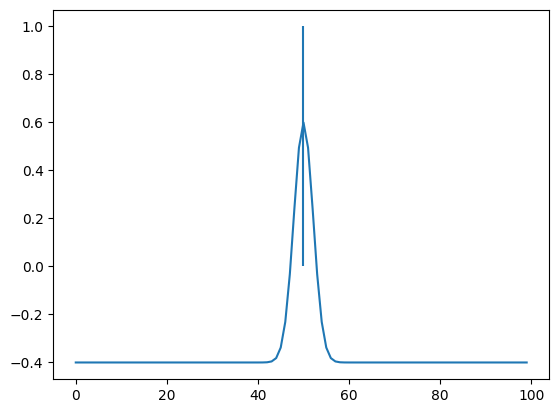

In [18]:
plt.plot(weights.hd.to.hd[weights.hd.to.hd.shape[0]//2])
plt.vlines(50, 0, 1)

2024-06-03 09:25:17 - DEBUG - Loaded backend inline version unknown.


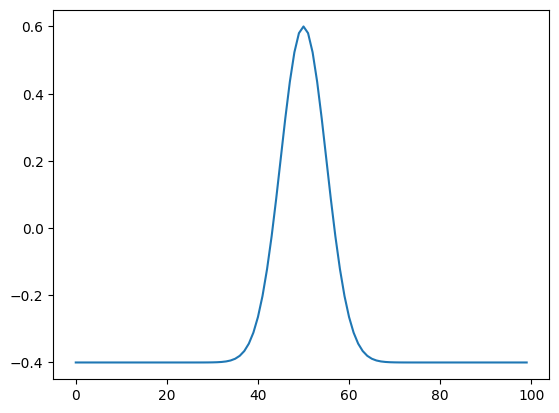

In [19]:
%matplotlib inline

def get_gaussian_kernel(
    n_neurons: int,
    sigma: float = .05,
    center: float = .5,
    amplitude: float = 1.
) -> np.ndarray:
    x = np.linspace(0, 1, n_neurons, endpoint=False)
    distance = np.minimum(np.abs(x - center), 2 * np.pi - np.abs(x - center))
    gaussian = amplitude*np.exp(-(distance**2) / (2 * sigma**2))

    return gaussian

plt.plot(
    get_gaussian_kernel(
        100
    ) - .4
)

In [40]:
from dataclasses import dataclass

@dataclass
class HDAttractorsContainer:
    hd_attractor: Attractor
    cw_rotation: Attractor
    ccw_rotation: Attractor


class HDCallback(BaseCallback):
    def __init__(
        self,
        hd_attractor: Attractor,
        cw_rot_attractor: Attractor,
        ccw_rot_attractor: Attractor,
        init_timesteps: int = 30,
        hd_cue_scale: float = 60,
    ):
        super().__init__()
        self.init_timesteps = init_timesteps
        self.hd_cue_scale = hd_cue_scale
        self.total_steps = init_timesteps

        self.hd_attractor = hd_attractor
        self.cw_rot_attractor = cw_rot_attractor
        self.ccw_rot_attractor = ccw_rot_attractor
        self.hd_estim = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'dynamics_params',  # Dynamic parameters including dt, mode, and step.
            'movement_params',  # Movement parameters including position and direction.
            'hd_cue',  # HD cue array for external directional cues.
            'k_ratio',  # Ratio of excitation/inhibition for HD cells.
            'activity',  # Neural activity levels.
            'connectivity',  # Connectivity matrices between neural populations.
            'weights',  # Synaptic weights between neurons.
            'rates',  # Firing rates of neurons.
            'hd_attractors',
            'dead_neurons'
        ]

        cache['hd_cue'] = np.zeros(len(self.hd_attractor.kernel))
        cache['hd_attractors'] = HDAttractorsContainer(
            self.hd_attractor,
            self.cw_rot_attractor,
            self.ccw_rot_attractor
        )
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params.dt

    def on_step_begin(self, step: int):
        if self.total_steps == self.init_timesteps:
            logging.debug('HD CUE INITIATED')


        if self.total_steps != 0:
            self.total_steps -= 1
            self.hd_cue += self.hd_cue_scale*get_hd_cue(self.movement_params.direction, len(self.rates.hd))
        else:
            if not np.all(self.hd_cue == 0):
                logging.debug('HD CUE REMOVED')
                self.hd_cue *= 0

        rotation = 0

        target = self.movement_params.rotate_target
        direction = self.movement_params.direction

        self.rates.hd[self.dead_neurons.indices] = 0


        if target is not None:
            angle_to_target = target

            diff = angle_to_target - direction
            if diff > np.pi:
                diff -= 2*np.pi
            elif diff < -np.pi:
                diff += 2*np.pi

            def angular_difference(angle1, angle2):
                diff = abs(angle1 - angle2)
                return min(diff, 2 * np.pi - diff)

            if self.hd_estim is not None and diff is not None:
                diff_assumed = angular_difference(angle_to_target, direction)
                diff_estimated = angular_difference(angle_to_target, self.hd_estim)
                if diff_assumed < diff_estimated:
                    # head direction is closer to the target than estimation
                    ...
                else:
                    diff = -diff
                # diff = -diff

            if np.isclose(diff, 0, atol=0.05):
                rotation = 0
            elif diff < 0:
                rotation = (self.cw_rot_attractor(self.rates.hd.T)@self.rates.hd.T).T
            elif diff > 0:
                rotation = (self.ccw_rot_attractor(self.rates.hd.T)@self.rates.hd.T).T

        ring = (self.hd_attractor(self.rates.hd.T)@self.rates.hd.T).T
        ring[self.dead_neurons.indices] = 0
        self.k_ratio.hd = (
            -self.activity.hd
            + (self.connectivity.hd.to.hd['phi']*ring)
            + self.hd_cue[:, np.newaxis]
            + (self.connectivity.rot.to.rot['phi']*rotation)
        )

        self.activity.hd += self.dt/self.connectivity.hd.to.hd['tau']*self.k_ratio.hd
        self.activity.hd[self.dead_neurons.indices] = 0
        self.rates.hd = 1/(1 + np.exp(-2*self.connectivity.hd.to.hd['beta']*(self.activity.hd - self.connectivity.hd.to.hd['alpha'])))
        self.rates.hd[self.dead_neurons.indices] = 0

        # HD estimation
        if self.total_steps == 0:
            popmax = np.where(self.rates.hd == np.max(self.rates.hd))[0][0]
            self.hd_estim = popmax*2*np.pi/(len(self.rates.hd) - 1) % (2*np.pi)

            # self.movement_params.direction = self.hd_estim



2024-06-03 09:25:18 - DEBUG - Loaded backend inline version unknown.


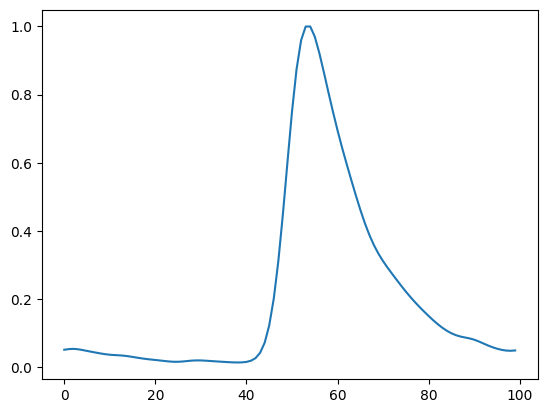

In [21]:
%matplotlib inline
plt.plot(
    weights.rot.to.rot[weights.rot.to.rot.shape[0]//2][::-1]
)

In [22]:
class HDPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['hd_ax_1'] = cache.fig.add_subplot(cache.gc[6:8, :])
        cache['hd_ax_2'] = cache.fig.add_subplot(cache.gc[8:10, :])
        cache['hd_ax_3'] = cache.fig.add_subplot(cache.gc[10:, :])
        self.requires = [
            'hd_ax_1',
            'hd_ax_2',
            'hd_ax_3',
            'fig',
            'rates',
            'weights',
            'activity',
            'k_ratio',
            'movement_params',
            'hd_attractors',
            'dead_neurons'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        rot_weights = None
        target = self.movement_params.rotate_target
        direction = self.movement_params.direction
        rotation = np.zeros_like(self.rates.hd)

        if target is not None:
            angle_to_target = target

            diff = angle_to_target - direction
            if diff > np.pi:
                diff -= 2*np.pi
            elif diff < -np.pi:
                diff += 2*np.pi

            if np.isclose(diff, 0, atol=0.05):
                rotation = np.zeros_like(self.rates.hd)
            elif diff < 0:
                rotation = (self.hd_attractors.cw_rotation(self.rates.hd.T)@self.rates.hd.T).T
            elif diff > 0:
                rotation = (self.hd_attractors.ccw_rotation(self.rates.hd.T)@self.rates.hd.T).T

        if rot_weights is None:
            rot_weights = np.zeros_like(self.weights.rot.to.rot)

        self.hd_ax_1.plot(self.rates.hd, '.')

        for index in self.dead_neurons.indices:
            self.hd_ax_1.axvline(x=index, color='r', ymin=0, ymax=1)

        self.hd_ax_2.plot((self.hd_attractors.hd_attractor(self.rates.hd.T)@self.rates.hd.T).T, '.')
        self.hd_ax_3.plot(rotation, '.')

    def on_clean(self):
        self.hd_ax_1.clear()
        self.hd_ax_1.set_ylim(0, 1)
        self.hd_ax_2.clear()
        self.hd_ax_3.clear()

In [23]:
from typing import Literal, Mapping


class RotationCallback(BaseCallback):
    def __init__(
        self,
        rotation_speed: float
    ):
        super().__init__()
        self.rotation_speed = rotation_speed

    def set_cache(self, cache: Mapping, on_repeat: Literal['raise'] | Literal['ignore'] | Literal['overwrite'] = 'raise'):
        self.requires = [
            'movement_params',
        ]
        super().set_cache(cache, on_repeat)

    def on_step_begin(self, step: int):
        if self.movement_params.direction is not None and\
            self.movement_params.rotate_target is not None:
            if self.movement_params.direction != self.movement_params.rotate_target:
                diff = self.movement_params.rotate_target - self.movement_params.direction
                if diff > np.pi:
                    diff -= 2*np.pi
                elif diff < -np.pi:
                    diff += 2*np.pi

                if np.isclose(diff, 0, atol=0.05):
                    self.movement_params.rotate_target = self.movement_params.direction
                elif diff < 0:
                    self.movement_params.direction -= self.rotation_speed
                elif diff > 0:
                    self.movement_params.direction += self.rotation_speed

                self.movement_params.direction %= 2*np.pi

In [ ]:
class RotSpeedPlotter(ArtistCallback):
    def __init__(self, coords: tuple[float, float], alpha = .5):
        super().__init__()
        self.coords = coords
        self.direction_prev = None
        self.alpha = alpha
        self.ewma_prev = None

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['rot_ax'] = cache.fig.add_subplot(cache.gc[1, 1])
        self.requires = [
            'rot_ax',
            'dynamics_params',
            'movement_params',
            'activity',
            'hd_attractors',
            'rates'
        ]
        super().set_cache(cache, on_repeat)

    def plot(self):

        pop = (self.hd_attractors.hd_attractor(self.rates.hd.T)@self.rates.hd.T).T
        ind = np.where(pop == pop.max())[0][0]

        if self.direction_prev is None:
            diff = 0
        else:
            diff = abs(self.direction_prev - ind)

        self.direction_prev = ind

        instant_rotation_speed = diff/len(self.rates.hd)

        if self.ewma_prev is None:
            self.previous_ewma = instant_rotation_speed
        else:
            self.previous_ewma = (self.alpha * instant_rotation_speed) + ((1 - self.alpha) * self.previous_ewma)


        self.rot_ax.text(
            *self.coords,
            f'Speed: {self.previous_ewma : .2f} s'
        )

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.rot_ax.clear()
        self.rot_ax.set_axis_off()

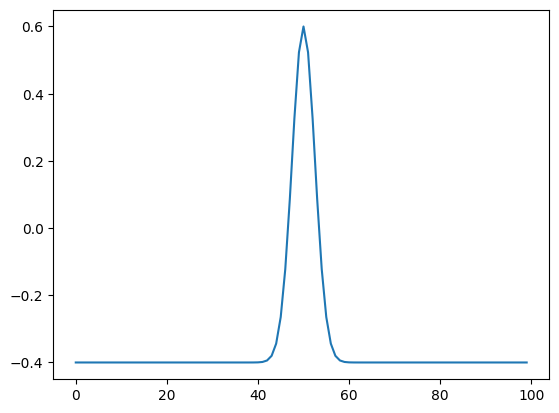

In [25]:
attr = Attractor(get_gaussian_kernel(n_hd_neurons, .025) - .4)
plt.plot(attr.kernel)

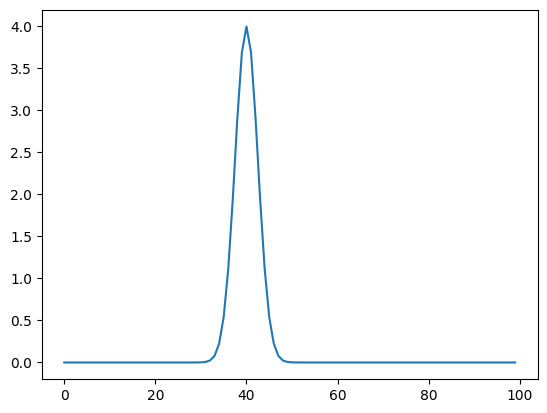

In [26]:
attr = Attractor(get_gaussian_kernel(n_hd_neurons, .025, .4, 4))
plt.plot(attr.kernel)

In [1]:
from bbtoolkit.dynamics import DynamicsManager
from bbtoolkit.dynamics.callbacks.viz import PlottingCallback
from bbtoolkit.models.bb.callbacks import TimerCallback
from bbtoolkit.models.bb.structures import ClickParameters, DynamicParameters
from bbtoolkit.structures import DotDict
from bbtoolkit.dynamics.callbacks.movement import MovementParameters

%matplotlib qt

dt = .005

direction = np.pi/2

cache = DotDict()
cache['dynamics_params'] = DynamicParameters(dt, None)
cache['click_params'] = ClickParameters()
cache['movement_params'] = MovementParameters(direction=np.pi/2)
cache['weights'] = weights.copy()
cache['activity'] = activity.copy()
cache['rates'] = rates.copy()
cache['k_ratio'] = k_ratio.copy()
cache['connectivity'] = connectivity.copy()
cache['dead_neurons'] = DotDict(indices=np.random.randint(0, 100, size=40))


dynamics = DynamicsManager(
    dt,
    callbacks=[
        RotationCallback(np.pi/100),
        HDCallback(
            Attractor(get_gaussian_kernel(n_hd_neurons, .025, amplitude=1) - .4),
            Attractor(get_gaussian_kernel(n_hd_neurons, .025, .4, 4)),
            Attractor(get_gaussian_kernel(n_hd_neurons, .025, .6, 4)),
            # Attractor(weights.rot.to.rot[weights.rot.to.rot.shape[0]//2]),
            # Attractor(weights.rot.to.rot[weights.rot.to.rot.shape[0]//2][::-1])
        ),
        TimerCallback(),
        PlottingCallback(
            [
                PolarCirclePlotter(),
                TimerPlotter((0, 0)),
                # RotSpeedPlotter((0, 0), 0.0000001),
                HDPlotter(),
                MouseEventCallback(),
            ],
            update_rate=5,
            fig_kwargs=dict(figsize=(10, 10)),
            gc_kwargs=dict(nrows=12, ncols=12)
        )
    ],
    cache=cache
)


for _ in dynamics(True):
    print('out: ', _)

ModuleNotFoundError: No module named 'bbtoolkit'

In [ ]:
cache.movement_params

{'angle': 3.141592653589793}